<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Bangla_Accent_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing dependencies and importing libraries

In [ ]:
!pip install resampy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import resampy

## Importing metadata to access audio files

In [ ]:
audio_dataset_path='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata=pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/metadata.csv')

In [ ]:
metadata.head()

,file_name,folder_name,accent
0,barishal_audio_01.wav,barishal,barishal
1,barishal_audio_02.wav,barishal,barishal
2,barishal_audio_03.wav,barishal,barishal
3,barishal_audio_04.wav,barishal,barishal
4,barishal_audio_05.wav,barishal,barishal


In [ ]:
len(metadata)

370

## EDA of random audio file

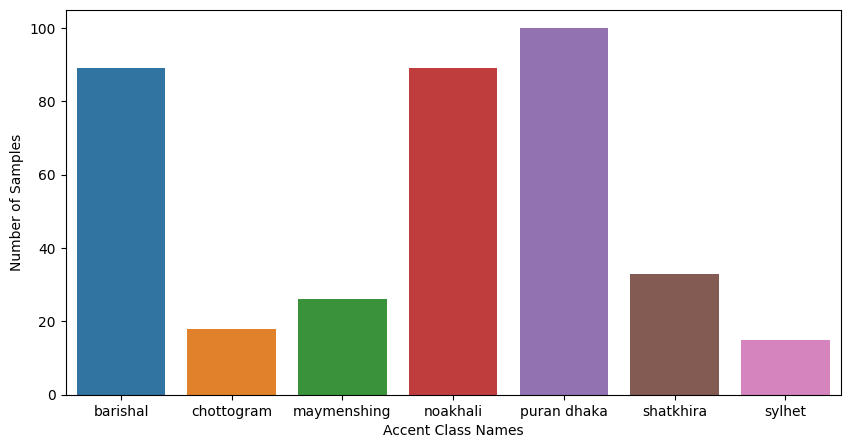

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x=metadata['accent'], ax=ax)
plt.xlabel('Accent Class Names')
plt.ylabel('Number of Samples')
plt.show()

In [ ]:
import librosa
import librosa.display

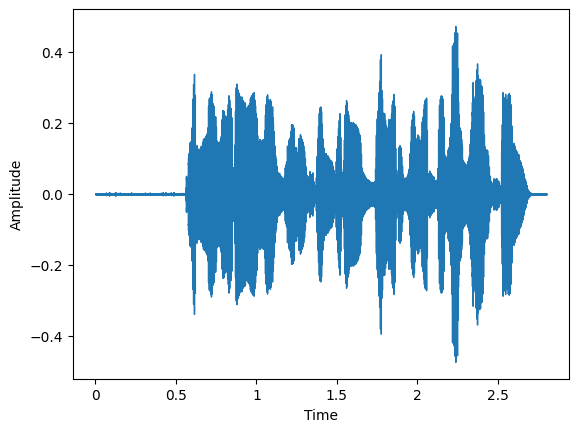

In [ ]:
audio_file = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/barishal/barishal_audio_01.wav'
signal, sr = librosa.load(audio_file, res_type='kaiser_fast')
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

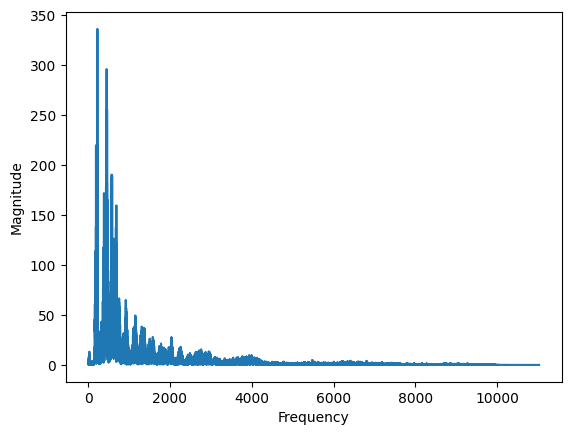

In [ ]:
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

# we have wsed forier transformation to exclude the mirror effect on the data.
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

# we can see that most of the energy is concentrated on the lower frequencies and the less energy liaes in the middle range frequency.

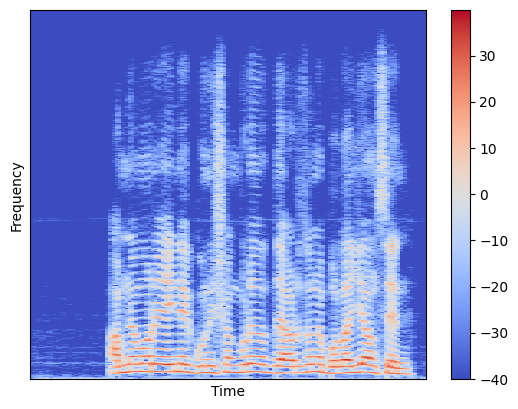

In [ ]:
n_fft = 2048
hop_length = 512

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

# Through spectrogram analysis we can see that it also states that the most of the energy consists in the lower frequency.
# The spectrogram remains stable through out time.

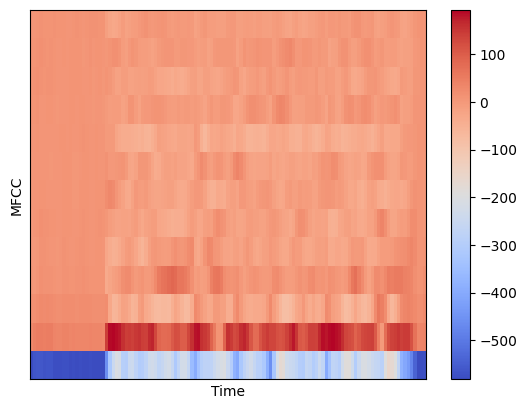

In [ ]:
# finding mfcc

MFCCs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)

librosa.display.specshow(MFCCs)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# This is the plot showing the MFCCs over time. There are 13 intervals in this spectrogram. The inteval represents the coffecients.
# We basically seeing here that how different MFCCs evolving over time.

## Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio
samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [ ]:
# defining a function that can extract features from audio files

def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features


In [ ]:
# collecting features for all the audio files

from tqdm import tqdm

extracted_features=[]

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  data = features_extractor(file_path)
  extracted_features.append([data, accent_label])

370it [02:21,  2.61it/s]


In [ ]:
# converting extracted_features to Pandas dataframe

extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-342.1416, 110.97826, -15.76264, 17.710947, -...",barishal
1,"[-299.67532, 113.31129, -15.29776, 16.303825, ...",barishal
2,"[-333.38495, 99.36539, -18.795504, 18.673012, ...",barishal
3,"[-306.11966, 120.16842, -26.124176, 14.367121,...",barishal
4,"[-329.08875, 114.36284, -7.601613, 18.476889, ...",barishal


## Creating train and test data

In [ ]:
# Split the dataset into independent and dependent dataset

X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [ ]:
X.shape

(370, 40)

In [ ]:
y.shape

(370,)

### Applying OneHot encoding for the accent classes

In [ ]:
# OneHot Encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y = encoder.fit_transform((extracted_features_df['class'].to_numpy()).reshape(-1,1))

In [ ]:
y.shape

(370, 7)

In [ ]:
y = y.toarray()

### Spliting features into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
X_train

array([[-3.2122290e+02,  1.3465916e+02, -8.4517488e+00, ...,
         3.4541664e+00,  1.3119210e+00,  5.0603070e+00],
       [-3.3660730e+02,  1.4341237e+02, -2.0363489e+01, ...,
        -4.6590567e-01, -1.4581741e-01, -4.0149922e+00],
       [-3.5933572e+02,  1.2823987e+02, -2.4713083e+01, ...,
        -1.6508708e+00,  4.6807466e+00,  3.2050231e+00],
       ...,
       [-2.9593256e+02,  9.7343727e+01, -3.7784264e+01, ...,
        -7.9790473e-01, -4.8253039e-01, -5.8494765e-01],
       [-3.3597443e+02,  1.4668161e+02, -2.6761105e+01, ...,
        -5.6227593e+00, -1.8982849e+00, -5.1146541e+00],
       [-3.5010129e+02,  1.5636789e+02, -6.4765716e+00, ...,
        -1.8918989e+00, -8.9912713e-01,  3.9256164e-01]], dtype=float32)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_train.shape

(296, 40)

In [ ]:
y_train.shape

(296, 7)

## Building ANN model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam

from sklearn import metrics

In [ ]:
# No of classes
num_labels=y.shape[1]

In [ ]:
model=Sequential()
# first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.2))

# final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
10/10 [==============================] - 6s 27ms/step - loss: 17.0509 - accuracy: 0.2365 - val_loss: 5.1478 - val_accuracy: 0.2973
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 9.9028 - accuracy: 0.2297 - val_loss: 2.9546 - val_accuracy: 0.3919
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 7.2476 - accuracy: 0.2635 - val_loss: 2.9023 - val_accuracy: 0.3108
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 4.8679 - accuracy: 0.2703 - val_loss: 1.3459 - val_accuracy: 0.5270
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 4.1036 - accuracy: 0.2196 - val_loss: 1.5600 - val_accuracy: 0.4730
Epoch 6/100
10/10 [==============================] - 0s 7ms/step - loss: 3.0911 - accuracy: 0.2568 - val_loss: 1.6749 - val_accuracy: 0.4595
Epoch 7/100
10/10 [==============================] - 0s 7ms/step - loss: 2.6042 - accuracy: 0.2973 - val_loss: 1.7274 - val_accuracy: 0.3784
Epoch 8/100

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.9324324131011963


### Making prediction and converting probability distribution into OneHot encoded vector

In [ ]:
y_pred_ann = model.predict(X_test)

predictions_ann = []

for row in y_pred_ann:
  label = np.zeros(7)
  label[np.argmax(row)] = 1
  label.reshape(1, -1)
  predictions_ann.append(label.tolist())
  label = None

3/3 [==============================] - 0s 3ms/step


In [ ]:
y_test_for_eval = encoder.inverse_transform(y_test)
predictions_ann = encoder.inverse_transform(predictions_ann)

In [ ]:
print(predictions_ann)

[['barishal']
 ['noakhali']
 ['puran dhaka']
 ['barishal']
 ['puran dhaka']
 ['noakhali']
 ['barishal']
 ['noakhali']
 ['barishal']
 ['puran dhaka']
 ['chottogram']
 ['barishal']
 ['puran dhaka']
 ['puran dhaka']
 ['noakhali']
 ['noakhali']
 ['maymenshing']
 ['noakhali']
 ['puran dhaka']
 ['barishal']
 ['maymenshing']
 ['puran dhaka']
 ['puran dhaka']
 ['sylhet']
 ['noakhali']
 ['noakhali']
 ['puran dhaka']
 ['chottogram']
 ['shatkhira']
 ['barishal']
 ['barishal']
 ['noakhali']
 ['noakhali']
 ['puran dhaka']
 ['puran dhaka']
 ['barishal']
 ['barishal']
 ['noakhali']
 ['puran dhaka']
 ['noakhali']
 ['barishal']
 ['barishal']
 ['noakhali']
 ['barishal']
 ['noakhali']
 ['puran dhaka']
 ['noakhali']
 ['shatkhira']
 ['barishal']
 ['noakhali']
 ['chottogram']
 ['noakhali']
 ['shatkhira']
 ['puran dhaka']
 ['maymenshing']
 ['shatkhira']
 ['barishal']
 ['noakhali']
 ['barishal']
 ['barishal']
 ['barishal']
 ['chottogram']
 ['chottogram']
 ['puran dhaka']
 ['puran dhaka']
 ['puran dhaka']
 ['n

### Finding Evaluation parameters

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions_ann))
print('Precision score: ', precision_score(y_test_for_eval, predictions_ann, average='weighted'))
print('Recall score   : ', recall_score(y_test_for_eval, predictions_ann, average='weighted'))
print('F1 Score       : ', f1_score(y_test_for_eval, predictions_ann, average='weighted'))

Accuracy score :  0.9324324324324325
Precision score:  0.9336034599192494
Recall score   :  0.9324324324324325
F1 Score       :  0.932059800664452


In [ ]:
print(classification_report(y_test_for_eval, predictions_ann))

              precision    recall  f1-score   support

    barishal       0.95      0.86      0.90        21
  chottogram       1.00      1.00      1.00         5
 maymenshing       1.00      1.00      1.00         4
    noakhali       0.86      0.90      0.88        21
 puran dhaka       0.94      1.00      0.97        17
   shatkhira       1.00      1.00      1.00         5
      sylhet       1.00      1.00      1.00         1

    accuracy                           0.93        74
   macro avg       0.97      0.97      0.97        74
weighted avg       0.93      0.93      0.93        74



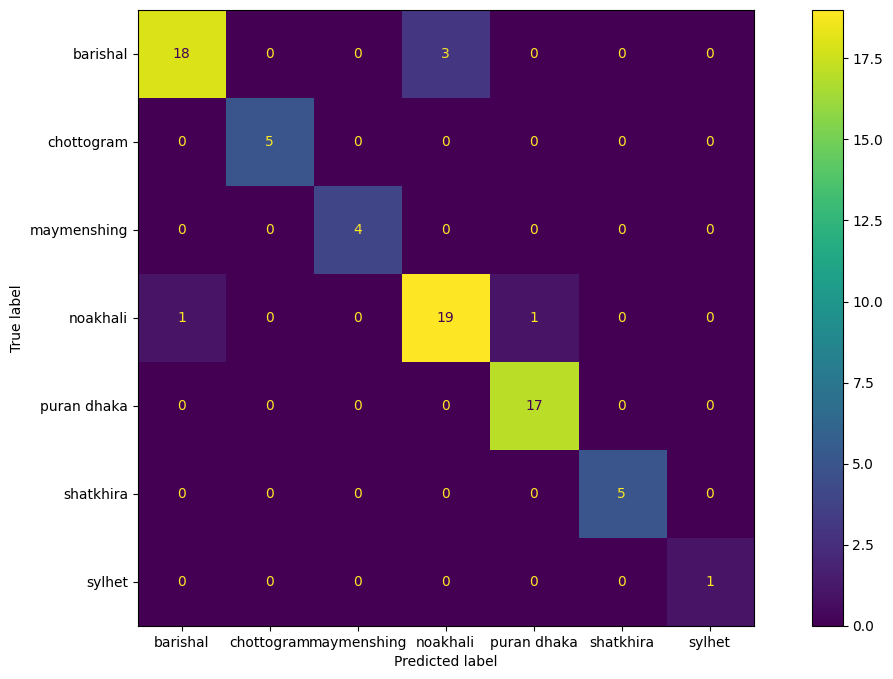

In [ ]:
cm = confusion_matrix(y_test_for_eval, predictions_ann, labels=metadata['accent'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
fig, ax = plt.subplots(figsize=(15,8))
disp.plot(ax=ax)
plt.show()

## Building LSTM model

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
model = tf.keras.Sequential()
# first layer after input layer
model.add(LSTM(100,input_shape=(40,1)))
model.add(Dropout(0.2))
# second layer
model.add(Dense(100, activation='relu'))
# third layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# forth layer
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 64)                6464      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 48)                3120      
                                                                 
 dropout_5 (Dropout)         (None, 48)               

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
10/10 [==============================] - 5s 60ms/step - loss: 1.8821 - acc: 0.1926 - val_loss: 1.8110 - val_acc: 0.3378
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 1.7473 - acc: 0.3041 - val_loss: 1.6955 - val_acc: 0.3514
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 1.6772 - acc: 0.2939 - val_loss: 1.5719 - val_acc: 0.3649
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 1.5245 - acc: 0.3345 - val_loss: 1.4236 - val_acc: 0.3649
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 1.4536 - acc: 0.3378 - val_loss: 1.3793 - val_acc: 0.3649
Epoch 6/100
10/10 [==============================] - 0s 11ms/step - loss: 1.3678 - acc: 0.3581 - val_loss: 1.3069 - val_acc: 0.3378
Epoch 7/100
10/10 [==============================] - 0s 11ms/step - loss: 1.2834 - acc: 0.4223 - val_loss: 1.2625 - val_acc: 0.4459
Epoch 8/100
10/10 [==============================] - 0s 12ms/step - loss: 1.

In [ ]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7027027010917664


### Making predictions into OneHot encoded format and converting it into real classs names

In [ ]:
y_pred_lstm = model.predict(X_test)

predictions_lstm = []

for row in y_pred_lstm:
  label = np.zeros(7)
  label[np.argmax(row)] = 1
  label.reshape(1, -1)
  predictions_lstm.append(label.tolist())
  label = None

3/3 [==============================] - 0s 4ms/step


In [ ]:
predictions_lstm = encoder.inverse_transform(predictions_lstm)

In [ ]:
print(predictions_lstm)

[['barishal']
 ['sylhet']
 ['puran dhaka']
 ['barishal']
 ['shatkhira']
 ['noakhali']
 ['barishal']
 ['noakhali']
 ['barishal']
 ['puran dhaka']
 ['maymenshing']
 ['puran dhaka']
 ['puran dhaka']
 ['puran dhaka']
 ['noakhali']
 ['sylhet']
 ['maymenshing']
 ['noakhali']
 ['puran dhaka']
 ['barishal']
 ['maymenshing']
 ['noakhali']
 ['shatkhira']
 ['sylhet']
 ['noakhali']
 ['puran dhaka']
 ['barishal']
 ['maymenshing']
 ['shatkhira']
 ['puran dhaka']
 ['barishal']
 ['noakhali']
 ['noakhali']
 ['barishal']
 ['sylhet']
 ['barishal']
 ['puran dhaka']
 ['noakhali']
 ['noakhali']
 ['sylhet']
 ['barishal']
 ['barishal']
 ['sylhet']
 ['barishal']
 ['noakhali']
 ['puran dhaka']
 ['noakhali']
 ['shatkhira']
 ['barishal']
 ['noakhali']
 ['chottogram']
 ['noakhali']
 ['shatkhira']
 ['puran dhaka']
 ['maymenshing']
 ['puran dhaka']
 ['barishal']
 ['shatkhira']
 ['barishal']
 ['barishal']
 ['barishal']
 ['maymenshing']
 ['chottogram']
 ['puran dhaka']
 ['puran dhaka']
 ['puran dhaka']
 ['puran dhaka'

### Finding evaluation parameters

In [ ]:
print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions_lstm))
print('Precision score: ', precision_score(y_test_for_eval, predictions_lstm, average='weighted'))
print('Recall score   : ', recall_score(y_test_for_eval, predictions_lstm, average='weighted'))
print('F1 Score       : ', f1_score(y_test_for_eval, predictions_lstm, average='weighted'))

Accuracy score :  0.7027027027027027
Precision score:  0.7816498220909985
Recall score   :  0.7027027027027027
F1 Score       :  0.7198642988116672


In [ ]:
print(classification_report(y_test_for_eval, predictions_lstm))

              precision    recall  f1-score   support

    barishal       0.83      0.71      0.77        21
  chottogram       1.00      0.40      0.57         5
 maymenshing       0.57      1.00      0.73         4
    noakhali       0.94      0.76      0.84        21
 puran dhaka       0.62      0.59      0.61        17
   shatkhira       0.50      0.80      0.62         5
      sylhet       0.17      1.00      0.29         1

    accuracy                           0.70        74
   macro avg       0.66      0.75      0.63        74
weighted avg       0.78      0.70      0.72        74



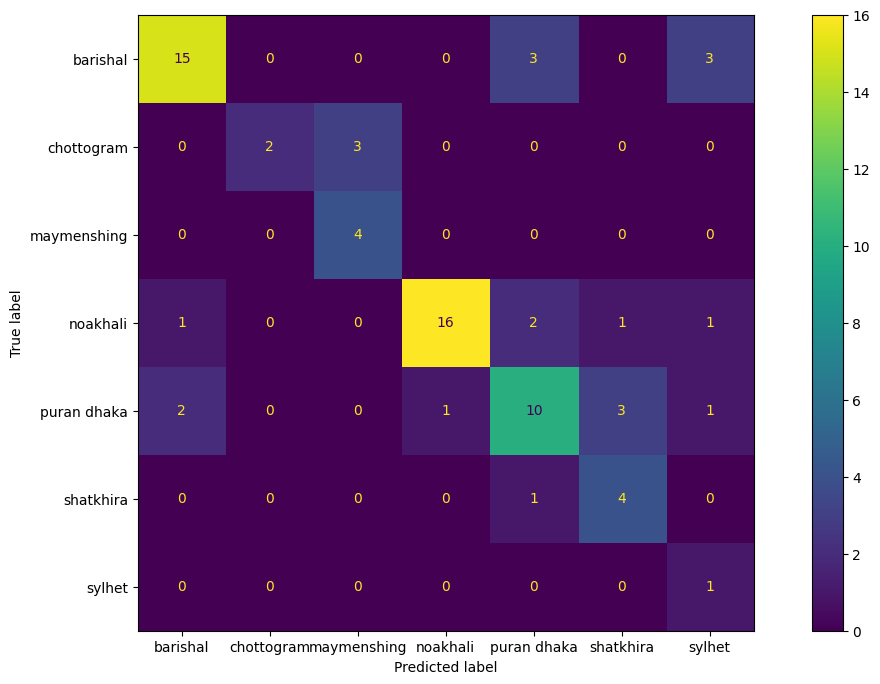

In [ ]:
cm = confusion_matrix(y_test_for_eval, predictions_lstm, labels=metadata['accent'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
fig, ax = plt.subplots(figsize=(15,8))
disp.plot(ax=ax)
plt.show()